# ML NLP
La evaluación consiste en realizar un análisis de NLP, siguiendo la guía planteada en clase y realizando los procesos de limpieza, tokenización, y Part of Speech.

Se realizar el proceso con el siguiente conjunto de datos
https://www.kaggle.com/datasets/luisdiegofv97/imdb-dataset-of-50k-movie-reviews-spanish

Entregables
- Enviar el notebook con todas las celdas ejecutadas
- Usar los review en español definidos en el conjunto
- Realizar el proceso con una muestra del 10% del conjunto de datos
- Realizar el proceso con el 100% del conjunto de datos
- Realizar la comparación entre los resultado del 10% y del 100%

In [ ]:
#librerias necesarias para el análisis
import gzip
import json
import string
import re
import time

import numpy as np                                                               
import matplotlib.pyplot as plt

import nltk # imports the natural language toolkit
import pandas as pd
import plotly

from collections import Counter
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt') ## Tokenizer

[nltk_data] Downloading package punkt to /Users/nicolaycc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Lectura de la información


Para verificar el formato de los registros podemos revisar el archivo verificando los primeros items. Como se puede observar el archivo no corresponde a una estructura csv (separado por comas) o algo similar, cada registro se encuentra delimitado por `{ }` y para cada atributo se tiene la forma:
"ATRIBUTO" : "VALOR".

### Lectura del archivo en formato csv

Pandas cuenta con método de lectura de archivos en formato csv
Lo primero que debemos realizar es una lectura del archivo, teniendo la instrucción, se realiza la lectura del 100% de los datos.

In [ ]:
df = pd.read_csv('datasets/IMDB Dataset SPANISH.csv', index_col=0)

Para extraer una muestra del 10% de los datos se ejecuta el siguiente comando, es importante notar que se asigna el argumento `random_state` para que siempre que se ejecute el programa obtengamos como resultado la misma muestra porque utilizamos la misma semilla.

In [ ]:
df10 = df.sample(frac=0.1, random_state=123)

#### Exploración general del conjunto de datos

El archivo cuenta con 4 columnas de información, en particular las de mas interés en este caso son review_es que contiene las reviews realizadas por los usuarios y sentimiento, que es el sentimiento del usuario con respecto a la película.

In [ ]:
df.head()

,review_en,review_es,sentiment,sentimiento
0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo
1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo
2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo
3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo
4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo


Para analizar mejor el conjunto de datos se revisan las frecuencias de ocurrencia de estas evaluaciones, es decir cuales son las proporciones de calificaciones en cada escala.

In [ ]:
#100% de los datos
frecuencias = df[['review_es', 'sentimiento']].groupby(['sentimiento']).count()
frecuencias

,review_es
sentimiento,
negativo,25000
positivo,25000


In [ ]:
#10% de los datos
frecuencias10 = df10[['review_es', 'sentimiento']].groupby(['sentimiento']).count()
frecuencias10


,review_es
sentimiento,
negativo,2481
positivo,2519


Realizando una gráfica de barras de las frecuencias de ocurrencia, podemos ver con mayor facilidad la proporción de cada una de las calificaciones

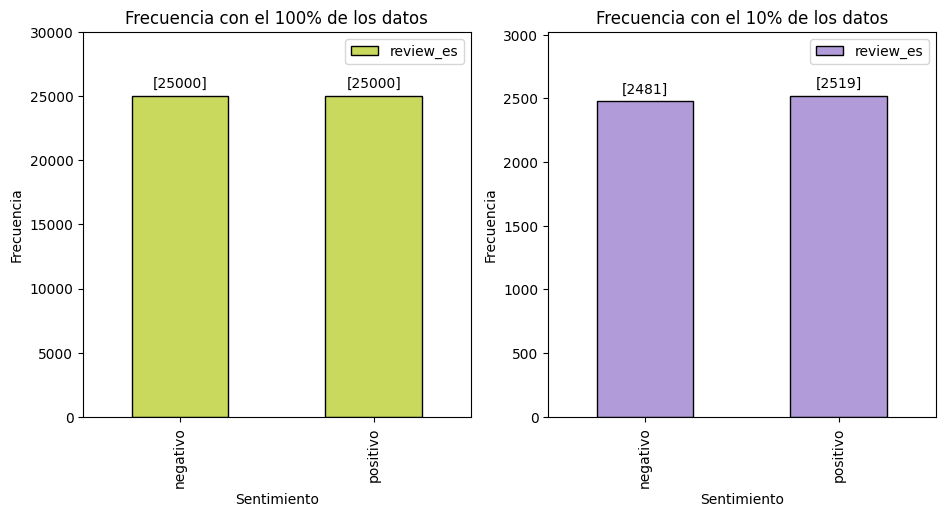

In [ ]:
#Generar la figura
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 5))

#generar los diagramas de barras
frecuencias.plot(kind='bar', ax=ax1, color='#C9D95E', edgecolor='black')
frecuencias10.plot(kind='bar', ax=ax2, color='#B19CD9', edgecolor='black')

#Asignar propiedades
for i, v in enumerate(frecuencias.values):
    ax1.annotate(str(v), xy=(i, v*1.06), ha='center', va='top')
ax1.set_title('Frecuencia con el 100% de los datos')
ax1.set_xlabel('Sentimiento')
ax1.set_ylabel('Frecuencia')
ax1.set_ylim(0, frecuencias.values.max() * 1.2)


for i, v in enumerate(frecuencias10.values):
    ax2.annotate(str(v), xy=(i, v*1.06), ha='center', va='top')
ax2.set_title('Frecuencia con el 10% de los datos')
ax2.set_xlabel('Sentimiento')
ax2.set_ylabel('Frecuencia')
ax2.set_ylim(0, frecuencias10.values.max() * 1.2)

#mostrar grafico
plt.show()


**En el diagrama de barras anterior podemos observar que la frecuencia de ocurrencia del sentimiento positivo y negativo es muy similar. Así también, con el conjunto de datos reducido (10% del total) encontramos que la distribución es muy similar. Las proporciones se mantienen muy similares en todo sentido.**

Otro proceso adicional consiste en calcular el número de caracteres de cada review (que tanto escriben en la critica los usuarios) y posteriormente realizar algunos análisis a partir de esa longitud.

In [ ]:
df.insert(loc=4, column= 'reviewlen', value= df['review_es'].str.len() )
df.head()


,review_en,review_es,sentiment,sentimiento,reviewlen
0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo,2004
1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo,1061
2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo,989
3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo,790
4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo,1406


## Limpieza del texto
Se deben limpiar las columnas que se vayan a utilizar para garantizar un correcto procesamiento de los datos. Para esto se define la función clean y se ejecuta en el conjunto de datos.

In [ ]:
def clean_text(text):
  text = re.sub(r'^RT[\s]+', '', text)
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
  text = re.sub(r'#', '', text)
  text = re.sub(r'@[A-Za-z0-9]+', '', text)
  return text

In [ ]:
df['review_es'] = df['review_es'].apply(clean_text)
df['review_es']

0        Uno de los otros críticos ha mencionado que de...
1        Una pequeña pequeña producción.La técnica de f...
2        Pensé que esta era una manera maravillosa de p...
3        Básicamente, hay una familia donde un niño peq...
4        El "amor en el tiempo" de Petter Mattei es una...
                               ...                        
49995    Pensé que esta película hizo un buen trabajo a...
49996    Mala parcela, mal diálogo, mala actuación, dir...
49997    Soy católica enseñada en escuelas primarias pa...
49998    Voy a tener que estar en desacuerdo con el com...
49999    Nadie espera que las películas de Star Trek se...
Name: review_es, Length: 50000, dtype: object

In [ ]:
df10['review_es'] = df10['review_es'].apply(clean_text)
df10['review_es']

11872    Esta película fue más allá de lo horrible, fue...
40828    A partir de esto, escribir el 'Halloween' de J...
36400    I must admit a slight disappointment with this...
5166     Oh dear! The BBC is not about to be knocked of...
30273    Es una película totalmente promedio con alguna...
                               ...                        
35438    Matt Cordell está de vuelta de entre los muert...
34278    Me gustó esta película, linda y divertida. Enc...
42135    Bettie Page fue un icono de la década de 1950 ...
21497    Así que las primeras cosas son las primeras .....
25894    Compré este juego en eBay, habiendo escuchado ...
Name: review_es, Length: 5000, dtype: object

--- 

# NLP (Procesamiento Natural del Lenguaje)

Para realizar procesamiento natural del lenguaje existen varias librerías, Spacy y NLTK son dos de las más usadas, en este caso vamos a realizar los ejercicios con NLTK.

Un proceso de NLP regularmente contiene una combinación de los siguientes procesos:

- Tokenización (separar las oraciones en palabras) - TFIDF
- Bag of words (Identificar la cantidad de veces que se repite cada palabra en un texto)
- Eliminar stop words (Remover palabras que no aportan significado intrínseco)
- Stemming (Eliminar sufijos o prefijos) Play**ing** -> Play
- Lemmatization (Reducir las palabras a su forma básica) Caring --> Care
- Topic Modeling (Latent Dirichlet Allocation - Aprendizaje no supervisado), Una palabra puede ser asignada a mas de un tópico.

    |   |   |
    |------------------------|------------|
    | Me gusta comer fruta al desayuno | TOPIC 1 |
    | El mejor lugar para ver un Panda es China | TOPIC 2 |
    | Vi a un Panda comiendo fruta | TOPIC 1 50% , 50% TOPIC 2 |


Ref. https://towardsdatascience.com/your-guide-to-natural-language-processing-nlp-48ea2511f6e1

En este ejercicio en particular comenzaremos con un proceso de Tokenización, y posteriormente identificaremos las palabras definidas como stop words en inglés para eliminarlas del análisis.

In [ ]:
#loading libraries

from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from functools import partial

El objetivo es analizar como se comportan los usuarios que escriben comentarios acerca de las películas y cual es la relación entre esos comentarios y la calificación que le otorgan a la pelicula.

## Tokenizer 
- Lo primero que debemos hacer para realizar un análisis de NLP es un proceso de Tokenización, es decir, separar las oraciones en palabras. Para esto usaremos el método RegexpTokenizer de nltk y el uso de Regex (Expresiones regulares).

    >https://regex101.com/r/JPcNjC/1


In [ ]:
# Functions to process the reviews

tokenizer = RegexpTokenizer(r'\w+')

- El segundo paso consiste en eliminar las palabras que se conocen como stopwords, son palabras que permiten hacer conexiones entre ideas, en principio que no aportan un significado por si solas, ej. aquí, allá, cuando, hasta.

In [ ]:
#descarga de las stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicolaycc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopword_set = set(stopwords.words('spanish')) #asignación para el idioma español

### Funciones para procesar los reviews

In [ ]:

def extract_reviews(bagtoprocess):
    return bagtoprocess.lower()
                            
def checkif_stopword(word, stopwords):
    return word not in stopwords

def filter_stopwords(tokens, stopwords):
    return list(filter(partial(checkif_stopword, stopwords=stopwords), tokens))
            


Usando las funciones previamente definidas realizamos el proceso de tokenización y eliminación de stop words para cada reseña realizada por los usuarios.

In [ ]:
# 100% de los datos
texto_critica = df['review_es'].squeeze() #convertir en una serie de Python
texto_critica_minusculas = texto_critica.map(extract_reviews) #all text in lower
texto_tokens = texto_critica_minusculas.map(tokenizer.tokenize) #just words
texto_limpio = texto_tokens.map(partial(filter_stopwords, stopwords=stopword_set)) #filtering stopwords

In [ ]:
# 10% de los datos
texto_critica10 = df10['review_es'].squeeze() #convertir en una serie de Python
texto_critica_minusculas10 = texto_critica10.map(extract_reviews) #all text in lower
texto_tokens10 = texto_critica_minusculas10.map(tokenizer.tokenize) #just words
texto_limpio10 = texto_tokens10.map(partial(filter_stopwords, stopwords=stopword_set)) #filtering stopwords

In [ ]:
#100% de los datos
print(texto_limpio.head())
print(len(texto_limpio))

0    [críticos, mencionado, después, ver, solo, 1, ...
1    [pequeña, pequeña, producción, técnica, filmac...
2    [pensé, manera, maravillosa, pasar, tiempo, fi...
3    [básicamente, familia, niño, pequeño, jake, pi...
4    [amor, tiempo, petter, mattei, película, visua...
Name: review_es, dtype: object
50000


In [ ]:
#10% de los datos
print(texto_limpio10.head())
print(len(texto_limpio10))

11872    [película, allá, horrible, grano, s, industria...
40828    [partir, escribir, halloween, john, carpenter,...
36400    [i, must, admit, slight, disappointment, with,...
5166     [oh, dear, the, bbc, is, not, about, to, be, k...
30273    [película, totalmente, promedio, secuencias, a...
Name: review_es, dtype: object
5000


### Resultado de la Tokenización
Para ver el resultado de un comentario tokenizado, y con las stopwords eliminadas vamos a imprimir el primer ejemplo.

In [ ]:
print(texto_critica[0], '\n')
print(texto_limpio[0])

Uno de los otros críticos ha mencionado que después de ver solo 1 Oz Episodio, estará enganchado. Tienen razón, ya que esto es exactamente lo que sucedió conmigo. La primera cosa que me golpeó sobre Oz fue su brutalidad y sus escenas de violencia inconfiadas, que se encuentran a la derecha de la palabra. Confía en mí, este no es un espectáculo para los débiles de corazón o tímido. Este espectáculo no extrae punzones con respecto a las drogas, el sexo o la violencia. Es Hardcore, en el uso clásico de la palabra. Se llama OZ, ya que es el apodo dado al Penitenciario del Estado de Seguridad Máximo de Oswald. Se centra principalmente en la ciudad de Emeralda, una sección experimental de la prisión donde todas las células tienen frentes de vidrio y se enfrentan hacia adentro, por lo que la privacidad no es alta en la agenda. Em City es el hogar de muchos ... Fariarios, musulmanes, gangstas, latinos, cristianos, italianos, irlandeses y más ... así que las esposas, las miradas de muerte, las 

Teniendo en cuenta el objetivo (comparar entre comentarios positivos y negativos), y ahora que conocemos el concepto de tokenización, nos vamos a apoyar en la **librería de sklearn** de extracción de texto y la función **CountVectorizer**, que básicamente realiza el contenido de los tokens (palabras) para una serie de textos, en este caso, la columna que contiene los comentarios de los usuarios.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
#Convert a collection of text documents to a matrix of token counts.

def get_top_n_words(corpus, n=1, k=1):
    vec = CountVectorizer(ngram_range=(k, k), stop_words=stopwords.words('spanish'))
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

Como se mencionó inicialmente, normalmente el proceso de NLP involucra Tokenizar y calcular la frecuencia de las palabras. A partir de la función definida, calculamos la frecuencia de las palabras mas relevantes.

In [ ]:
# 100% de los datos
print("Para el 100% de los datos:")
common_words = get_top_n_words(df["review_es"], 20, 1)
for word, freq in common_words:
    print(word, freq)

Para el 100% de los datos:
película 151817
the 52405
si 35193
solo 28777
películas 28690
ser 26121
historia 26087
tan 24929
ver 24198
and 23718
realmente 23187
of 23111
to 20755
vez 19785
bien 17866
mejor 17551
gran 16960
puede 16030
hace 15640
tiempo 15390


In [ ]:
print("Para el 10% de los datos:")
common_words10 = get_top_n_words(df10["review_es"], 20, 1)
for word, freq in common_words10:
    print(word, freq)

Para el 10% de los datos:
película 15247
the 4694
si 3542
solo 2900
películas 2879
ser 2651
tan 2634
historia 2587
ver 2422
realmente 2337
of 2139
and 2069
vez 1947
bien 1831
gran 1813
mejor 1806
to 1806
puede 1620
hace 1548
tiempo 1515


Si graficamos lo encontrado anteriormente:

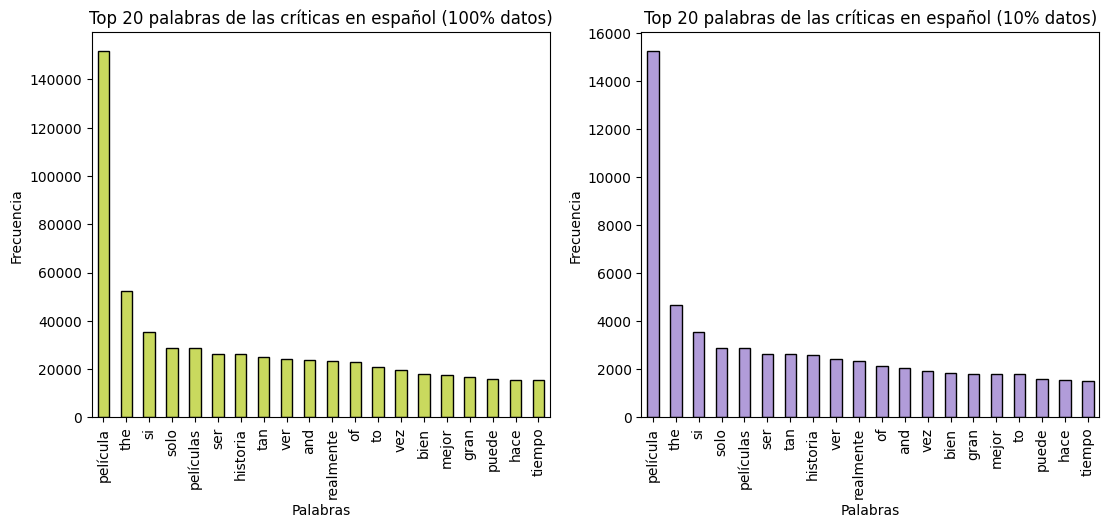

In [ ]:
#DataFrames
df_top_words = pd.DataFrame(common_words, columns=["words", "count"]) #100% datos
df_top_words10 = pd.DataFrame(common_words10, columns=["words", "count"]) #10% datos

# Graficar el primer DataFrame
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
df_top_words.groupby("words").sum()["count"].sort_values(ascending=False).head(20).plot(
    kind="bar", title="Top 20 palabras de las críticas en español (100% datos)",color='#C9D95E', edgecolor='black'
)
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")

# Graficar el segundo DataFrame
plt.subplot(1, 2, 2)
df_top_words10.groupby("words").sum()["count"].sort_values(ascending=False).head(20).plot(
    kind="bar", title="Top 20 palabras de las críticas en español (10% datos)",color='#B19CD9', edgecolor='black'
)
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")

# Mostrar la figura
plt.show()


Conclusión: **Se puede observar que los datos siguen la misma distribución en el conjunto del 100% y del 10%. En ambos casos la palabra que aparece con mayor frecuencia en la review es *pelicula*, así también, esta palabra se repite de una manera considerablemente mayor con respecto al resto.**

Ahora vamos a separar nuestro conjunto de datos, de acuerdo a un nuevo criterio definido de comentarios positivos con una calificación mayor a 3 y negativos con calificación inferior a 2.1

In [ ]:
df.head(10)

,review_en,review_es,sentiment,sentimiento,reviewlen
0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo,2004
1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo,1061
2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo,989
3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo,790
4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo,1406
5,"Probably my all-time favorite movie, a story o...",Probablemente mi película favorita de todos lo...,positive,positivo,724
6,I sure would like to see a resurrection of a u...,Seguro que me gustaría ver una resurrección de...,positive,positivo,839
7,"This show was an amazing, fresh & innovative i...","Este espectáculo fue una idea increíble, fresc...",negative,negativo,1034
8,Encouraged by the positive comments about this...,Alentados por los comentarios positivos sobre ...,negative,negativo,708
9,If you like original gut wrenching laughter yo...,"Si te gusta la risa original desgarradora, te ...",positive,positivo,186


Para esto usamos un filtro en el dataframe que retornará true o false dependiendo del cumplimiento de la función.

In [ ]:
# 100% de los datos
# Comentarios positivos
good_indices = df["sentimiento"] == "positivo"
good_reviews = df[good_indices]
# comentarios negativos
bad_indices = df["sentimiento"] == "negativo"
bad_reviews = df[bad_indices]

In [ ]:
#10% de los datos
# Comentarios positivos
good_indices10 = df10["sentimiento"] == "positivo"
good_reviews10 = df10[good_indices10]
# comentarios negativos
bad_indices10 = df10["sentimiento"] == "negativo"
bad_reviews10 = df10[bad_indices10]


Ahora realizamos un proceso similar de cálculo de frecuencia de palabras, solamente en los reviews que consideramos positivos.

In [ ]:
# 100% de los datos
common_words = get_top_n_words(good_reviews["review_es"], 20)
for word, freq in common_words:
    print(word, freq)


película 71879
the 28654
si 15134
historia 14545
películas 14142
and 13746
of 13121
solo 12576
ser 11945
ver 11523
to 11169
tan 10767
realmente 10726
gran 10529
bien 10247
vez 10138
mejor 9213
hace 8602
vida 8491
is 8452


In [ ]:
# 10% de los datos
common_words10 = get_top_n_words(good_reviews10["review_es"], 20)
for word, freq in common_words10:
    print(word, freq)

película 7374
the 2248
si 1532
historia 1434
películas 1430
solo 1275
ser 1189
ver 1170
realmente 1149
tan 1147
gran 1092
of 1087
bien 1068
vez 1024
and 997
mejor 959
vida 927
hace 900
puede 870
años 870


Observamos que palabras como película o si se usan con frecuencia en las críticas positivas.

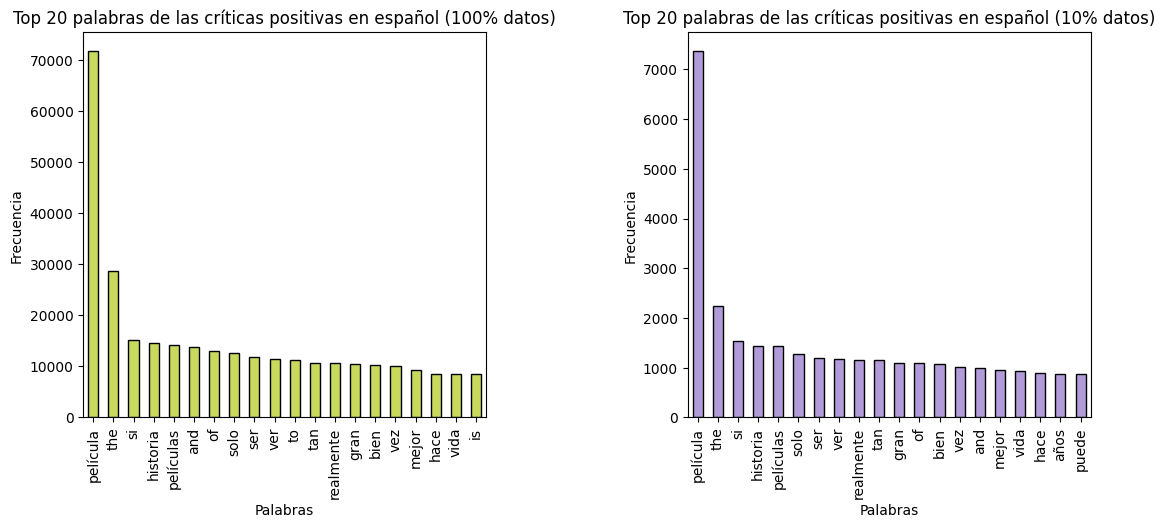

In [ ]:
# Data frames
df_positive = pd.DataFrame(common_words, columns=["words", 'count'])
df_positive10 = pd.DataFrame(common_words10, columns=["words", 'count'])

# Graficar el primer DataFrame
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
df_positive.groupby('words').sum()['count'].sort_values(ascending=False).head(20).plot(
    kind='bar', title='Top 20 palabras de las críticas positivas en español (100% datos)',
    color='#C9D95E', edgecolor='black'
)
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")

# Graficar el segundo DataFrame
plt.subplot(1, 2, 2)
df_positive10.groupby('words').sum()['count'].sort_values(ascending=False).head(20).plot(
    kind='bar', title='Top 20 palabras de las críticas positivas en español (10% datos)',
    color='#B19CD9', edgecolor='black'
)
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")

# Ajustar la ubicación de los subplots
plt.subplots_adjust(wspace=0.5)

# Mostrar la figura
plt.show()

**Al comparar los diagramas de barras entre el conjunto del 100% de datos y del 10% de los datos no encontramos diferencias en la distribución de las palabras. La palabra que más se repite es "película".**

Realizamos un proceso similar para los reviews negativos. Es interesante observar que la palabra good sigue siendo representativa.

In [ ]:
bad_reviews.head()

,review_en,review_es,sentiment,sentimiento,reviewlen
3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo,790
7,"This show was an amazing, fresh & innovative i...","Este espectáculo fue una idea increíble, fresc...",negative,negativo,1034
8,Encouraged by the positive comments about this...,Alentados por los comentarios positivos sobre ...,negative,negativo,708
10,Phil the Alien is one of those quirky films wh...,Phil El alienígena es una de esas películas pe...,negative,negativo,575
11,I saw this movie when I was about 12 when it c...,Vi esta película cuando tenía alrededor de 12 ...,negative,negativo,977


In [ ]:
# 100% de los datos
# Comentarios negativos
common_words = get_top_n_words(bad_reviews['review_es'], 20)
for word, freq in common_words:
    print(word, freq)

película 79938
the 23751
si 20059
solo 16201
películas 14548
ser 14176
tan 14162
ver 12675
realmente 12461
historia 11542
of 9990
and 9972
vez 9647
to 9586
tiempo 8438
mejor 8338
incluso 8068
puede 7731
bien 7619
hecho 7481


In [ ]:
# 10% de los datos - Comentarios negativos
common_words10 = get_top_n_words(bad_reviews10['review_es'], 20)
for word, freq in common_words10:
    print(word, freq)
    

película 7873
the 2446
si 2010
solo 1625
tan 1487
ser 1462
películas 1449
ver 1252
realmente 1188
historia 1153
and 1072
of 1052
to 998
vez 923
mejor 847
tiempo 794
simplemente 766
bien 763
hecho 754
puede 750


Realizando el diagrama de barras correspondiente para visualizar de mejor manera la información:

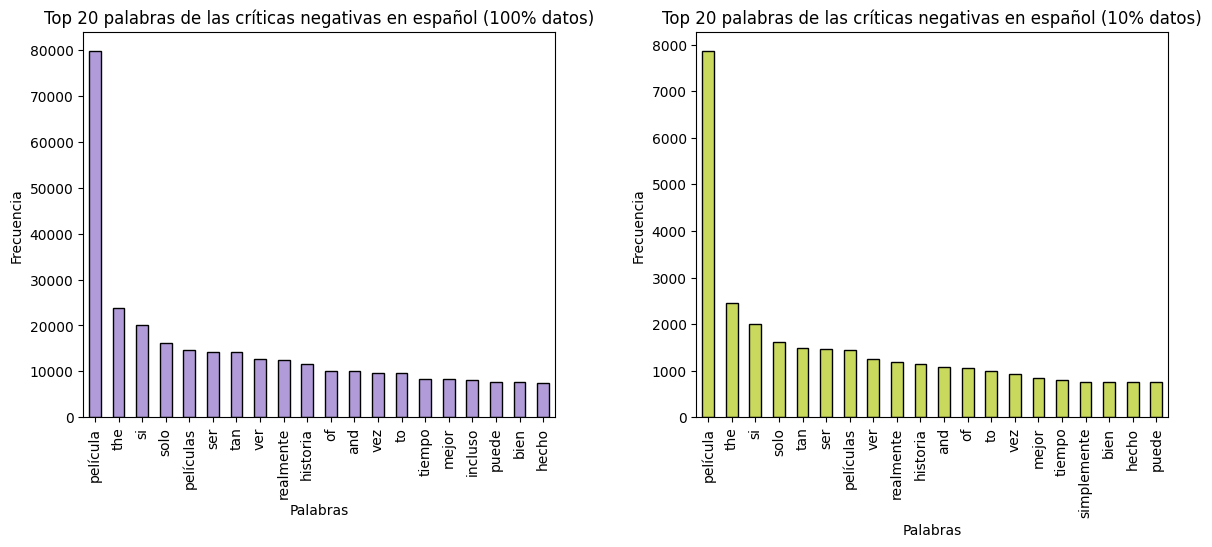

In [ ]:
#DataFrames
df_negative = pd.DataFrame(common_words, columns=['words', 'count'])
df_negative10 = pd.DataFrame(common_words10, columns=['words', 'count'])

# Graficar el primer DataFrame
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
df_negative.groupby('words').sum()['count'].sort_values(ascending=False).head(20).plot(
    kind='bar', title='Top 20 palabras de las críticas negativas en español (100% datos)',
    color='#B19CD9', edgecolor='black'
)
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")

# Graficar el segundo DataFrame
plt.subplot(1, 2, 2)
df_negative10.groupby('words').sum()['count'].sort_values(ascending=False).head(20).plot(
    kind='bar', title='Top 20 palabras de las críticas negativas en español (10% datos)',
    color='#C9D95E', edgecolor='black'
)
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")

# Ajustar la ubicación de los subplots
plt.subplots_adjust(wspace=0.3)

# Mostrar la figura
plt.show()


Conclusión: **Las palabras que más se repiten en las críticas negativas son muy similares a las que más aparecen en las críticas positivas. La distribución que siguen los conjuntos de datos del 100% y 10% es igual. La palabra que más frecuencia presenta es _película_ y sucede así tanto para el conjunto completo como para la muestra del 10%.**

Sin embargo, nuestro interés es detectar palabras que están en los reviews negativos y que normalmente no se encuentran en los reviews positivos.

Para esto construimos una función que calcule las 20 palabras con frecuencia mas alta, que solamente estén en reviews negativos .

In [ ]:
from collections import Counter
# https://docs.python.org/3/library/collections.html

def get_indicative_words(text1, text2, n=20):
    c1 = Counter(text1.lower().split(" "))
    c2 = Counter(text2.lower().split(" "))
    ind_words_1 = (c1 - c2).most_common(n) #most_common, método de la clase Counter
    ind_words_2 = (c2 - c1).most_common(n)    
    x, y = zip(*ind_words_2)
    #https://www.programiz.com/python-programming/methods/built-in/zip
    df_indicative = pd.DataFrame({'word': x, 'count': y})
    df_indicative.plot.barh(
        x='word', y='count', figsize=(10,10)
    )
    return(c1)


Para el 100% de los datos encontramos:

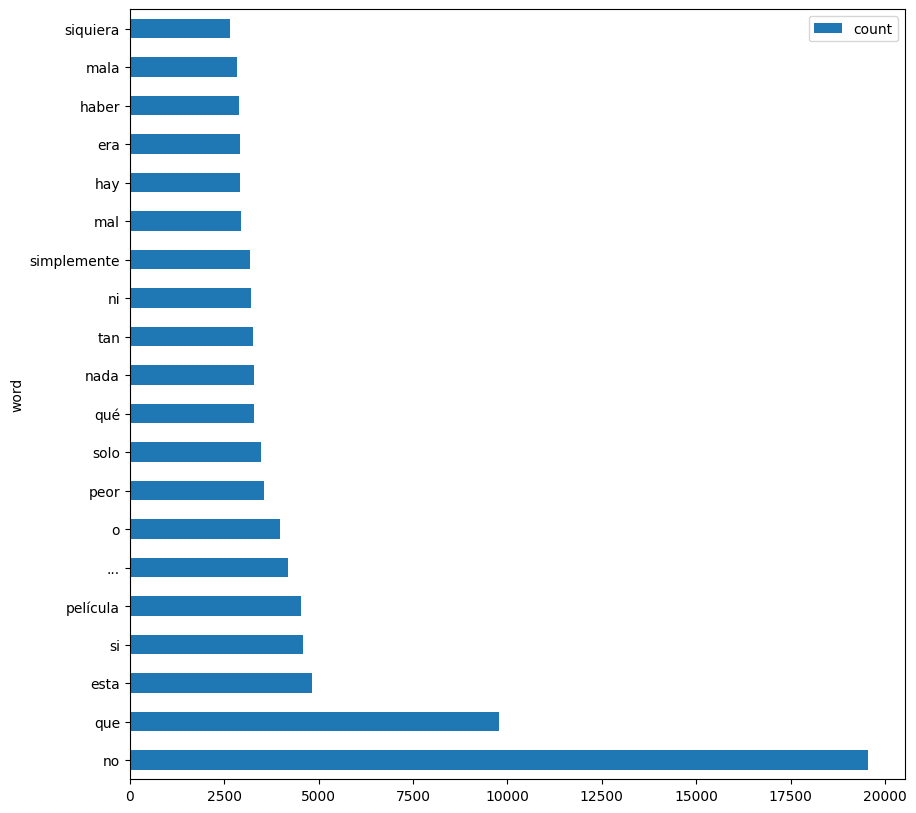

In [ ]:
c1 = get_indicative_words(' '.join(good_reviews['review_es']), ' '.join(bad_reviews['review_es']))

Y para el 10% de los datos:

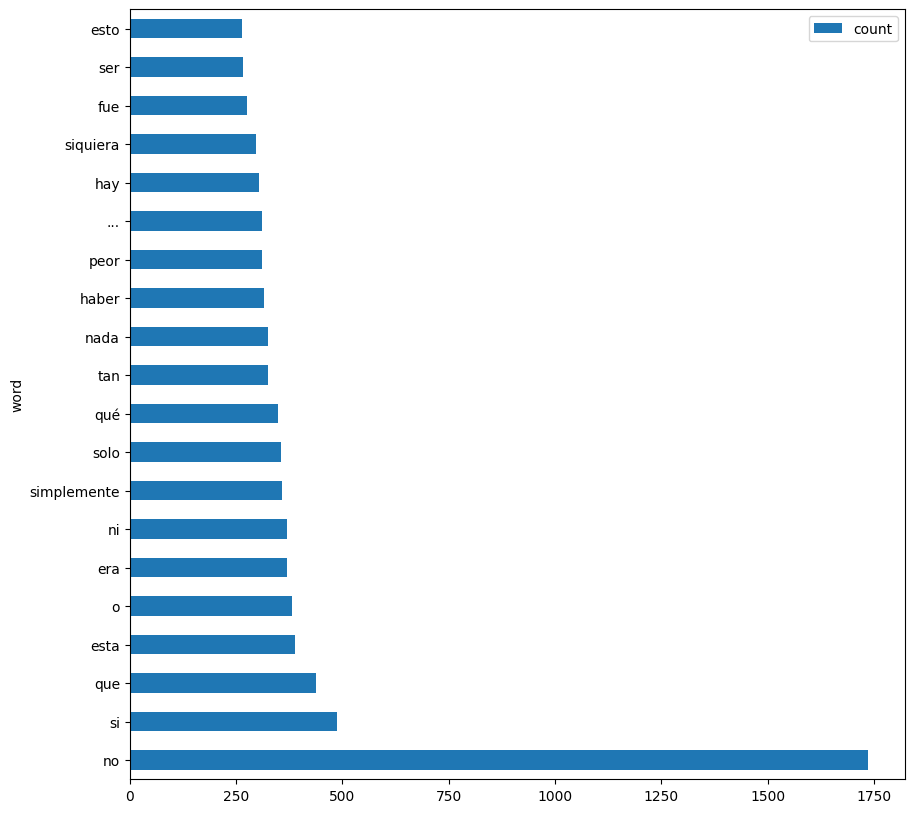

In [ ]:
c1_10 = get_indicative_words(' '.join(good_reviews10['review_es']), ' '.join(bad_reviews10['review_es']))

Conclusión: **Encontramos que las palabras que mas se repiten en reviews negativas son "no", "si", "que" y "o". Además, la palabra "no" tiene una frecuencia significativamente superior con respecto al resto de palabras. Sin embargo, es difícil llegar a una conclusión precisa ya que estas palabras son muy comunes en el lenguaje y no proporcionan mucha información por sí solas.**

Solo como referencia la palabra mas usada en los reviews positivos.

In [ ]:
llave = list(c1.keys())[0]
valor = list(c1.values())[0]
print (llave, valor)

uno 7060


**Como conclusión general -> el análisis de frecuencia de palabras es un primer paso útil, pero se necesitará un análisis más profundo y un contexto más amplio para sacar conclusiones significativas sobre las críticas de películas.**

# POS (Part of speech)

Uno de los procesamientos mas relevantes para encontrar significado y procesar adecuadamente un texto, se conoce como Part of Speech, este procedimiento hace referencia a encontrar no solamente los tokens de la oración, si no a identificar que tipo de rol juega esa palabra en el idioma, es decir, si es un nombre, verbo, adjetivos, etc.

NLTK cuenta con un método denominado pos_tag para etiquetar las palabras que han resultado del proceso de tokenización 

*Nota. En este ejemplo no se filtran stop words para mostrar el comportamiento sobre la frase completa*

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('tagsets')
nltk.download('vader_lexicon')

#https://www.nltk.org/book/ch05.html


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nicolaycc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/nicolaycc/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/nicolaycc/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/nicolaycc/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nicolaycc/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Ayuda adicional de POS tag puede obtenerse con la ayuda propia de la librería NLTK
nltk.help.upenn_tagset('CD$')
nltk.help.upenn_tagset('NN$')
nltk.help.upenn_tagset('NNPS$')

CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...
NNPS: noun, proper, plural
    Americans Americas Amharas Amityvilles Amusements Anarcho-Syndicalists
    Andalusians Andes Andruses Angels Animals Anthony Antilles Antiques
    Apache Apaches Apocrypha ...


Se realiza el procesamiento POS para toda la fila de sentimiento:

In [ ]:
#definir oración
sentence = df['review_es'][0]

#tokenizar
words = nltk.word_tokenize(sentence)
print(words)

#mostrar las etiquetas ['CD','FW','NN','NNS','NNP','NNPS'] de las palabras de la oración
words_1 = [k for k,v in nltk.pos_tag(words) if v in ['CD','FW','NN','NNS','NNP','NNPS']]
print(words_1)


['Uno', 'de', 'los', 'otros', 'críticos', 'ha', 'mencionado', 'que', 'después', 'de', 'ver', 'solo', '1', 'Oz', 'Episodio', ',', 'estará', 'enganchado', '.', 'Tienen', 'razón', ',', 'ya', 'que', 'esto', 'es', 'exactamente', 'lo', 'que', 'sucedió', 'conmigo', '.', 'La', 'primera', 'cosa', 'que', 'me', 'golpeó', 'sobre', 'Oz', 'fue', 'su', 'brutalidad', 'y', 'sus', 'escenas', 'de', 'violencia', 'inconfiadas', ',', 'que', 'se', 'encuentran', 'a', 'la', 'derecha', 'de', 'la', 'palabra', '.', 'Confía', 'en', 'mí', ',', 'este', 'no', 'es', 'un', 'espectáculo', 'para', 'los', 'débiles', 'de', 'corazón', 'o', 'tímido', '.', 'Este', 'espectáculo', 'no', 'extrae', 'punzones', 'con', 'respecto', 'a', 'las', 'drogas', ',', 'el', 'sexo', 'o', 'la', 'violencia', '.', 'Es', 'Hardcore', ',', 'en', 'el', 'uso', 'clásico', 'de', 'la', 'palabra', '.', 'Se', 'llama', 'OZ', ',', 'ya', 'que', 'es', 'el', 'apodo', 'dado', 'al', 'Penitenciario', 'del', 'Estado', 'de', 'Seguridad', 'Máximo', 'de', 'Oswald', '.

Se realiza el proceso de etiquetar el texto (PART OF SPEECH TAGGING):

In [ ]:
tag = nltk.pos_tag(words) #PART OF SPEECH TAGGING
tag[:10] #ver las primeras 10 palabras con su etiqueta

[('Uno', 'NNP'),
 ('de', 'FW'),
 ('los', 'FW'),
 ('otros', 'JJ'),
 ('críticos', 'NN'),
 ('ha', 'NN'),
 ('mencionado', 'NN'),
 ('que', 'NN'),
 ('después', 'NN'),
 ('de', 'IN')]

Para agrupar a las palabras según su etiqueta se ejecuta lo siguiente:

In [ ]:
entities = nltk.chunk.ne_chunk(tag) #NER
entities.pprint() #ver las entidades nombradas

(S
  (GPE Uno/NNP)
  de/FW
  los/FW
  otros/JJ
  críticos/NN
  ha/NN
  mencionado/NN
  que/NN
  después/NN
  de/IN
  ver/FW
  solo/FW
  1/CD
  Oz/NNP
  Episodio/NNP
  ,/,
  estará/JJ
  enganchado/NN
  ./.
  (PERSON Tienen/NNP)
  razón/NN
  ,/,
  ya/PRP
  que/VBP
  esto/JJ
  es/NN
  exactamente/NN
  lo/NN
  que/NN
  sucedió/NN
  conmigo/NN
  ./.
  La/NNP
  primera/NN
  cosa/NN
  que/IN
  me/PRP
  golpeó/VBP
  sobre/JJ
  Oz/NNP
  fue/NN
  su/NN
  brutalidad/NN
  y/NN
  sus/NN
  escenas/FW
  de/FW
  violencia/FW
  inconfiadas/NNS
  ,/,
  que/NN
  se/NN
  encuentran/VBD
  a/DT
  la/NN
  derecha/FW
  de/FW
  la/FW
  palabra/FW
  ./.
  Confía/NNP
  en/IN
  mí/NN
  ,/,
  este/NN
  no/DT
  es/NN
  un/RB
  espectáculo/JJ
  para/NN
  los/NN
  débiles/VBZ
  de/IN
  corazón/FW
  o/JJ
  tímido/NN
  ./.
  (PERSON Este/NNP)
  espectáculo/VBZ
  no/DT
  extrae/JJ
  punzones/NNS
  con/VBP
  respecto/VB
  a/DT
  las/NN
  drogas/NN
  ,/,
  el/FW
  sexo/FW
  o/FW
  la/FW
  violencia/FW
  ./.
  Es/NNP
  Har

Podemos graficar también un diagrama que nos muestra la frecuencia de repetición de cada palabra dentro de la oración:

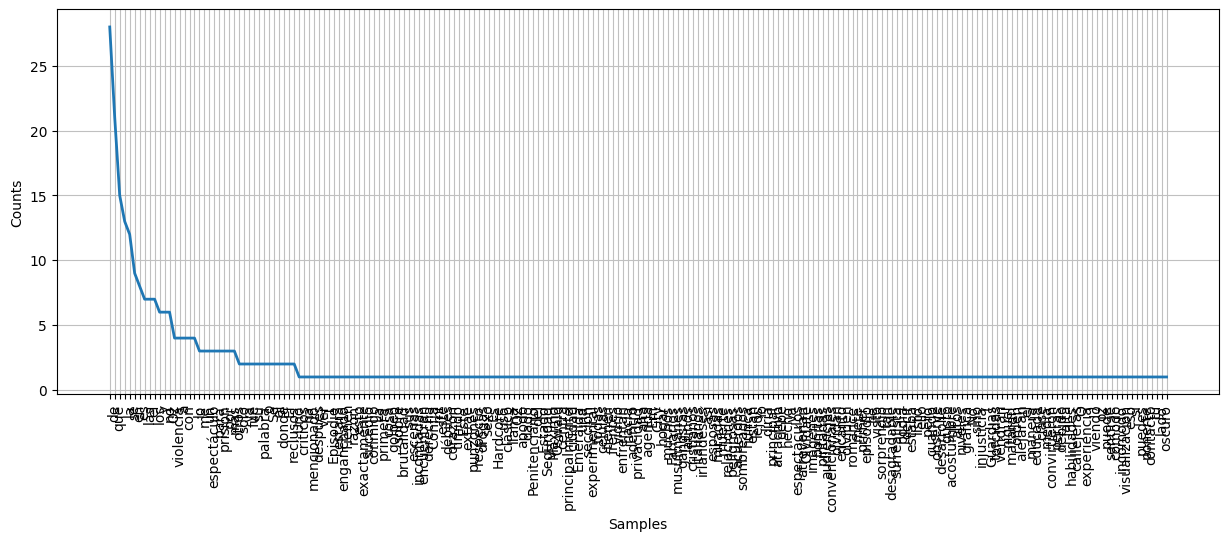

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
fd = nltk.FreqDist(words)
plt.figure(figsize=(15, 5))
fd.plot()

Encontramos que la palabra que más se repite es el conector "de", esto tiene mucho sentido puesto que es una palabra muy común en el lenguaje.

## Análisis del sentimiento

A partir del texto proporcionado se va a determinar el sentimiento de la oración. NLTK ofrece una implementación del análisis de sentimientos VADER, sin embargo esta solamente sirve para textos en inglés. 

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia=SentimentIntensityAnalyzer() #creación del objeto SentimentIntensityAnalyzer

VADER funciona realizando un análisis de la oración y extrae el sentimiento calificandolo de 1 a 0 según la categoría _negativo, neutro o positivo_, por ejemplo:

In [ ]:
sia.polarity_scores("I am so happy") #análisis de sentimiento

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

Debido a que VADER funciona solamente con textos en inglés se debe realizar el análisis de sentimientos con otra biblioteca. Para esto se elige la bilbioteca **TextBlob** la cual permite realizar un análisis de sentimiento de una forma sencilla traduciendo el texto al idioma inglés y posteriormente analizando la frase.

In [ ]:
from textblob import TextBlob

In [ ]:
TextBlob('Odio este producto').translate(from_lang='es',to='en').sentiment

Sentiment(polarity=-0.8, subjectivity=0.9)

El código anterior traduce el texto al idioma inglés y posteriormente realiza el análisis de sentimiento. Da como resultado el parámetro "polarity" el cual nos indica que tan positivo o negativa es el texto en una escala de -1 a 1, siendo 1 lo más positivo.

#### Aplicando el análisis de sentimiento en todo el conjunto de datos

Se define la función de análisis de sentimiento:

In [ ]:
def get_polarity(text):
  analysis = TextBlob(text)
  if text != '':
    result = analysis.translate(from_lang = 'es', to = 'en').sentiment.polarity
    time.sleep(5)
    return result

In [ ]:
df['review_es']

0        Uno de los otros críticos ha mencionado que de...
1        Una pequeña pequeña producción.La técnica de f...
2        Pensé que esta era una manera maravillosa de p...
3        Básicamente, hay una familia donde un niño peq...
4        El "amor en el tiempo" de Petter Mattei es una...
                               ...                        
49995    Pensé que esta película hizo un buen trabajo a...
49996    Mala parcela, mal diálogo, mala actuación, dir...
49997    Soy católica enseñada en escuelas primarias pa...
49998    Voy a tener que estar en desacuerdo con el com...
49999    Nadie espera que las películas de Star Trek se...
Name: review_es, Length: 50000, dtype: object

En este punto, se decide trabajar solamente con el 1% del conjunto de datos puesto que realizar un análisis de sentimiento por cada una de las reviews requiere de grandes recursos computacionales.

In [ ]:
df1 = df.sample(frac=0.0001, random_state=123)

df1['polarity'] = df1['review_es'].apply(get_polarity)

In [ ]:
df1['polarity']

11872   -0.058333
40828    0.198435
36400    0.086524
5166    -0.010556
30273    0.024167
Name: polarity, dtype: float64

Se define una función para determinar el sentimiento a partir de la polaridad.

In [ ]:
def x_range(x):
  if x > 0:
    return "positivo"
  else:
    return "negativo"

Se aplica la función:

In [ ]:
df1['result'] = df1['polarity'].apply(x_range)
df1.head()

,review_en,review_es,sentiment,sentimiento,reviewlen,polarity,result
11872,"This movie was beyond awful, it was a pimple o...","Esta película fue más allá de lo horrible, fue...",negative,negativo,844,-0.058333,negativo
40828,As of this writing John Carpenter's 'Halloween...,"A partir de esto, escribir el 'Halloween' de J...",positive,positivo,1968,0.198435,positivo
36400,I must admit a slight disappointment with this...,I must admit a slight disappointment with this...,positive,positivo,5097,0.086524,positivo
5166,Oh dear! The BBC is not about to be knocked of...,Oh dear! The BBC is not about to be knocked of...,negative,negativo,970,-0.010556,negativo
30273,its a totally average film with a few semi-alr...,Es una película totalmente promedio con alguna...,negative,negativo,791,0.024167,positivo


Podemos observar que clasifico correctamente la mayoría de reviews teniendo en cuenta la columna de "result" y comparandola con "sentimiento". Realizando un conteo a modo de resumen de la clasificación, encontramos:

In [ ]:
df1['result'].value_counts()

result
positivo    3
negativo    2
Name: count, dtype: int64

Finalmente, podemos calcular el porcentaje de aciertos:

In [ ]:
# contar cuántas veces el resultado es igual al sentimiento
aciertos = df1[df1['sentimiento'] == df1['result']].shape[0]

# calcular porcentaje de aciertos
porcentaje_aciertos = aciertos / df1.shape[0] * 100

# imprimir porcentaje de aciertos
print(f'El porcentaje de aciertos es: {porcentaje_aciertos:.2f}%')

El porcentaje de aciertos es: 80.00%


### Conclusiones finales
- El procesamiento de la base de datos de críticas de películas se realizó de manera exitosa.
- Los resultados obtenidos al comparar los datos del analisis de sentimiento con TextBlob y los datos reales de sentimiento fueron similares, lo que sugiere que el modelo utilizado fue efectivo en la clasificación de sentimientos.
- Las frecuencias de palabras pueden contener muchas palabras comunes del lenguaje, lo que dificulta la obtención de información significativa.
- Se recomienda realizar un análisis exhaustivo y profundo que incluya el contexto y la semántica de las palabras para obtener conclusiones más precisas y significativas.
- La validación y comparación de los resultados con los datos reales es fundamental para evaluar la precisión y efectividad del modelo utilizado.